# Testing Code


Before submiting the final answers, this jupyter notebook could be used to experiment and verify if the code is working!


Here we are taking inspiration from two of the top projects:
 * https://huggingface.co/spaces/baixianger/RobotPai
 * https://huggingface.co/spaces/fisherman611/gaia-agent/

In [ ]:
%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
import json

## Load Data

In [ ]:
# Load the metadata.jsonl file
with open('data/metadata.jsonl', 'r') as jsonl_file:
    json_list = list(jsonl_file)

json_QA = []
for json_str in json_list:
    json_data = json.loads(json_str)
    json_QA.append(json_data)

### Data Analyses

Here we analyze the data in order to find what tools we need to build a robust agent

In [ ]:
import random

random_samples = random.sample(json_QA, 3)
for sample in random_samples:
    print("=" * 50)
    print(f"Task ID: {sample['task_id']}")
    print(f"Question: {sample['Question']}")
    print(f"Level: {sample['Level']}")
    print(f"Final Answer: {sample['Final answer']}")
    print(f"Annotator Metadata: ")
    print(f"  ├── Steps: ")
    for step in sample['Annotator Metadata']['Steps'].split('\n'):
        print(f"  │      ├── {step}")
    print(f"  ├── Number of steps: {sample['Annotator Metadata']['Number of steps']}")
    print(f"  ├── How long did this take?: {sample['Annotator Metadata']['How long did this take?']}")
    print(f"  ├── Tools:")
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        print(f"  │      ├── {tool}")
    print(f"  └── Number of tools: {sample['Annotator Metadata']['Number of tools']}")
print("=" * 50)

In [ ]:
### Linking to supabase server
import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import SupabaseVectorStore
from supabase.client import Client, create_client


load_dotenv()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2") #  dim=768

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [ ]:
# Questions to list of documents
from langchain.schema import Document
docs = []
for sample in json_QA:
    content = f"Question : {sample['Question']}\n\nFinal answer : {sample['Final answer']}"
    doc = {
        "content" : content,
        "metadata" : { 
            "source" : sample['task_id']
        },
        "embedding" : embeddings.embed_query(content),
    }
    docs.append(doc)

# upload the documents to the vector database
try:
    response = supabase.table("documents").insert(docs).execute()
    print("Data inserted successfully:", response)
except Exception as e:
    print("Error inserting data into Supabase:", e)

In [17]:
# add items to vector database
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding= embeddings,
    table_name="documents",
    query_name="match_documents",
)
retriever = vector_store.as_retriever()

In [20]:
query = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
# matched_docs = vector_store.similarity_search(query, 2)
docs = retriever.invoke(query)
docs[0]

Document(metadata={'source': '840bfca7-4f7b-481a-8794-c560c340185d'}, page_content='Question : On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?\n\nFinal answer : 80GSFC21M0002')

In [21]:
from collections import Counter, OrderedDict

tools = []
for sample in json_QA:
    for tool in sample['Annotator Metadata']['Tools'].split('\n'):
        tool = tool[2:].strip().lower()
        if tool.startswith("("):
            tool = tool[11:].strip()
        tools.append(tool)
tools_counter = OrderedDict(Counter(tools))
print("List of tools used in all samples:")
print("Total number of tools used:", len(tools_counter))
for tool, count in tools_counter.items():
    print(f"  ├── {tool}: {count}")

List of tools used in all samples:
Total number of tools used: 83
  ├── web browser: 107
  ├── image recognition tools (to identify and parse a figure with three axes): 1
  ├── search engine: 101
  ├── calculator: 34
  ├── unlambda compiler (optional): 1
  ├── a web browser.: 2
  ├── a search engine.: 2
  ├── a calculator.: 1
  ├── microsoft excel: 5
  ├── google search: 1
  ├── ne: 9
  ├── pdf access: 7
  ├── file handling: 2
  ├── python: 3
  ├── image recognition tools: 12
  ├── jsonld file access: 1
  ├── video parsing: 1
  ├── python compiler: 1
  ├── video recognition tools: 3
  ├── pdf viewer: 7
  ├── microsoft excel / google sheets: 3
  ├── word document access: 1
  ├── tool to extract text from images: 1
  ├── a word reversal tool / script: 1
  ├── counter: 1
  ├── excel: 3
  ├── image recognition: 5
  ├── color recognition: 3
  ├── excel file access: 3
  ├── xml file access: 1
  ├── access to the internet archive, web.archive.org: 1
  ├── text processing/diff tool: 1
  ├── gi

## Graph Implementation

Here we build the agent graph with LangGraph to solve those tasks!

In [ ]:
system_prompt = """
You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
==========================
Here is a few examples showing you how to answer the question step by step.
"""
for i, samples in enumerate(random_samples):
    system_prompt += f"\nQuestion {i+1}: {samples['Question']}\nSteps:\n{samples['Annotator Metadata']['Steps']}\nTools:\n{samples['Annotator Metadata']['Tools']}\nFinal Answer: {samples['Final answer']}\n"
system_prompt += "\n==========================\n"
system_prompt += "Now, please answer the following question step by step.\n"

# save the system_prompt to a file
with open('system_prompt.txt', 'w') as f:
    f.write(system_prompt)

In [ ]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()
print(system_prompt)


You are a helpful assistant tasked with answering questions using a set of tools.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.
Here is a few examples showing you how to answer the question step by step.

Question 1: Of the cities within the United States where U.S. presidents were born, which two are the farthest apart from the westernmost to the easternmost going east, giving the city names only? Give them to me in alphabetical order, in a comma-separated list
Steps:
1. Searched "cities where us presidents are born" on Google.
2. Opened "List of presidents of the United States by home state" on Wikipedia.
3. Searched the eastern cities to find the easternmost one (Braintree, MA).
4. Checked the westernmost city (Honolulu, HI).
Tools:
1. Search engine
2. Web browser
Final Answer: Braintree, Honolulu

Question 2: An o

In [53]:
import dotenv
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from tools.searchtools import question_retrieve_tool, wiki_search, web_search, arvix_search
from tools.mathtools import multiply, add, subtract, divide, modulus

# Define the retriever from supabase
load_dotenv()

tools = [
    multiply,
    add,
    subtract,
    divide,
    modulus,
    wiki_search,
    web_search,
    arvix_search,
    question_retrieve_tool
]

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [49]:
# load the system prompt from the file
with open('system_prompt.txt', 'r') as f:
    system_prompt = f.read()


# System message
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
    """Assistant node"""
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Compile graph
graph = builder.compile()

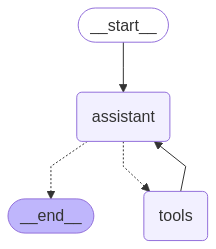

In [50]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [51]:
question = "On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?"
messages = [HumanMessage(content=question)]
messages = graph.invoke({"messages": messages})

In [52]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

On June 6, 2023, an article by Carolyn Collins Petersen was published in Universe Today. This article mentions a team that produced a paper about their observations, linked at the bottom of the article. Find this paper. Under what NASA award number was the work performed by R. G. Arendt supported by?
================================== Ai Message ==================================

Steps:
1. Search for the article "Carolyn Collins Petersen Universe Today June 6, 2023" to find the article.
2. Open the article and look for a link to the paper.
3. Open the paper and search for "R. G. Arendt" and "NASA award number".
Tool Calls:
  web_search (3d857d83-a516-4285-9b13-da3c245b8b97)
 Call ID: 3d857d83-a516-4285-9b13-da3c245b8b97
  Args:
    input: Carolyn Collins Petersen Universe Today June 6 2023
================================= Tool Message =================================
Name: web_search

{"web_results": [